# Practica 1 - Landscapes

le conjunto de dato que vamos a utilizar para entrenar a nuestro modelos representa diferentes países o áreas terrestres interiores con 14 clases diferentes. Debido a su dificultad, las imágenes son reales y no han sido sometidas a ningún pretratamiento práctico; será necesario maximizar las características de las imágenes para mejorar los resultados.

## Libraries and extensions
Lo primero que debemos hacer antes de comenzar con la manipulacion de nuestros datos es importar todas las librerias que vayamos a utlizar

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from skimage.feature import daisy, local_binary_pattern, hog
from os.path import isfile, join, exists
from skimage import data, exposure
import IPython.display as display
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from skimage import io, color
from sklearn import svm
from os import listdir
from PIL import Image
import pandas as pd
import numpy as np
import shutil
import cv2
import os


Instale estos paquetes si es necesario

In [31]:
%pip install opencv-python
%pip install scikit-image
%pip install tqdm

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## Transformación y preparación del conjunto de datos
El primer problema que encontramos es que las imágenes no tienen las mismas dimensiones, por lo que debemos escalar todas las imágenes al mismo tamaño para entrenar nuestro modelo. El mejor tamaño es el mínimo de todas las imágenes, con el fin de evitar píxeles inútiles de información, ya que si aumentamos el tamaño de las imágenes pequeñas estamos haciendo que aparezcan píxeles que no existían y alteraríamos los resultados.

In [2]:

def find_smallest_image_in_directory(directory):
    image_files = [file for file in os.listdir(directory) if file.lower().endswith('.jpg')]

    if not image_files:
        print(f"No images found in the directory {directory}.")
        return None, None

    min_size = float('inf')
    min_image = None

    for filename in image_files:
        image = Image.open(os.path.join(directory, filename))
        width, height = image.size
        current_size = width * height

        if current_size < min_size:
            min_size = current_size
            min_image = filename

    return min_image, min_size

base_directory = "dat/a2/a2/data/train"


for subdirectory in os.listdir(base_directory):
    subdirectory_path = os.path.join(base_directory, subdirectory)

    if os.path.isdir(subdirectory_path):
        min_image, min_size = find_smallest_image_in_directory(subdirectory_path)

        if min_image is not None:
            print(f"Directorio {subdirectory}")
            print(f"Tama: {Image.open(os.path.join(subdirectory_path, min_image)).size}")
        else:
            print(f"  No hay nada")



Found in bedroom: image_0001.jpg
Dimensions: (200, 200)
Found in Coast: image_0006.jpg
Dimensions: (200, 200)
Found in Forest: image_0003.jpg
Dimensions: (200, 200)
Found in Highway: image_0009.jpg
Dimensions: (200, 200)
Found in industrial: image_0002.jpg
Dimensions: (200, 200)
Found in Insidecity: image_0005.jpg
Dimensions: (200, 200)
Found in kitchen: image_0001.jpg
Dimensions: (200, 200)
Found in livingroom: image_0001.jpg
Dimensions: (200, 200)
Found in Mountain: image_0002.jpg
Dimensions: (200, 200)
Found in Office: image_0002.jpg
Dimensions: (200, 200)
Found in OpenCountry: image_0003.jpg
Dimensions: (200, 200)
Found in store: image_0001.jpg
Dimensions: (200, 200)
Found in Street: image_0001.jpg
Dimensions: (200, 200)
Found in Suburb: image_0002.jpg
Dimensions: (200, 200)
Found in TallBuilding: image_0010.jpg
Dimensions: (200, 200)


Como podemos comprobar, la imagen con una dimension menor mide (203, 200). Para mantener esto de la forma mas simple posible vamos a escalar todas las imagenes a un cuadrado de dimensiones (200,200). Hacemos el proceso de resize utilizando una funcion auxiliar, tanto en el conjunto de train como de test. 

In [3]:
def plot_file(fname):
    img_data=plt.imread(fname)
    plt.imshow(img_data,cmap='Greys_r')
    
def resize_images(type):
    # Directorio base
    base_directory = "dat/a2/a2/data/"+type+"/"

    # Iterar a través de los subdirectorios
    for subdirectory in os.listdir(base_directory):
        subdirectory_path = os.path.join(base_directory, subdirectory)

        if os.path.isdir(subdirectory_path):
            num_total_images = len([file for file in os.listdir(subdirectory_path) if file.lower().endswith('.jpg')])

            for filename in os.listdir(subdirectory_path):
                if filename.lower().endswith('.jpg'):
                    image_path = os.path.join(subdirectory_path, filename)
                    image = cv2.imread(image_path)
                    resized_image = cv2.resize(image, (200, 200)) 
                    cv2.imwrite(image_path, resized_image)

resize_images("train")
resize_images("test")

## Labels y categorias para entrenamiento
Una vez tenemos el conjunto de datos de manera uniforme pasamos a obtener las labels a partir de las carpetas, lo cual nos servira a la hora de entrenar nuestro modelo.

In [7]:
path="dat/a2/a2/data/train/"
category_names = listdir(path) 

for i in range(len(category_names)):
    print (category_names[i],'=',i)

print ('total de categorias:',len(category_names))

def get_filenames(path):
    onlyfiles = [path+f for f in listdir(path) if isfile(join(path, f))]
    return onlyfiles

dataset_filenames=[] 
dataset_labels=[]

for category in category_names:
    category_filenames=get_filenames(path+category+"/")##get all the filenames in that category
    category_labels=np.ones(len(category_filenames))*category_names.index(category) ##label the category with its index position
    category_labels = category_labels.astype(int)
    dataset_filenames=dataset_filenames+category_filenames
    dataset_labels=dataset_labels+list(category_labels)

print(len(dataset_filenames))
print(len(dataset_labels))

bedroom = 0
Coast = 1
Forest = 2
Highway = 3
industrial = 4
Insidecity = 5
kitchen = 6
livingroom = 7
Mountain = 8
Office = 9
OpenCountry = 10
store = 11
Street = 12
Suburb = 13
TallBuilding = 14
total categories: 15
1500
1500


Este proceso debemos realizarlo tambien para las carpetas de test, con el principal proposito de limpiar las carpetas. 

In [ ]:
test_path="dat/a2/a2/data/test/"
category_names = listdir(test_path) 

for i in range(len(category_names)):
    print (category_names[i],'=',i)

Como podemos ver hay una carpeta conflictiva que deberemos eliminar.

In [8]:
test_path="dat/a2/a2/data/test/"
category_names = listdir(test_path) 

shutil.rmtree(test_path+"livingRoom (Case Conflict)")

for i in range(len(category_names)):
    print (category_names[i],'=',i)

print ('total categories:',len(category_names))

test_filenames=[] ##list to keep path of all files in the database
test_labels=[]

for category in category_names:
    category_filenames=get_filenames(test_path+category+"/")##get all the filenames in that category
    category_labels=np.ones(len(category_filenames))*category_names.index(category) ##label the category with its index position
    category_labels = category_labels.astype(int)
    test_filenames=test_filenames+category_filenames
    test_labels=test_labels+list(category_labels)

print(len(test_filenames))
print(len(test_labels))

bedroom = 0
coast = 1
forest = 2
highway = 3
industrial = 4
insidecity = 5
kitchen = 6
livingRoom = 7
mountain = 8
office = 9
opencountry = 10
store = 11
street = 12
suburb = 13
tallbuilding = 14
total categories: 15
2985
2985


## Extraccion de los vectores de caracteristicas
En esta practica entrenaremos tres *Support Vector Machines* utilizando como datos de entrenamiento diferentes descriptores encargados de obtener caracteristicas de las imagenes con lo que formaremos el conocido como *vector de caracteristicas*.
Las transformaciones que utilizaremos son:
1. HOG (Histogram of Oriented Gradients)
2. Daisy feature descriptor
3. Local binary patterns
   
Creamos tres funciones para obtener las caracteristicas a partir de el path de la imagen

In [9]:

def extract_hog_features(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    win_size = (64, 64)
    block_size = (16, 16)
    block_stride = (8, 8)
    cell_size = (8, 8)
    nbins = 9
    hog = cv2.HOGDescriptor(win_size, block_size, block_stride, cell_size, nbins)
    features = hog.compute(image)

    return features

def extract_daisy_features(image_path):
    image = cv2.imread(image_path)
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    radius = 15
    rings = 3
    histograms = 8
    orientations = 8

    features = daisy(image_gray, step=8, radius=radius, rings=rings, histograms=histograms, orientations=orientations)
    return features.flatten()

def extract_local_binary_patterns(image_path):
    image = cv2.imread(image_path)
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    radius = 8
    n_points = 24
    method = 'uniform'

    features = local_binary_pattern(image_gray, P=n_points, R=radius, method=method)
    return features.flatten()

def extract_features(image_path, descriptor):
    if(descriptor == 'HOG'):
        return extract_hog_features(image_path)
    elif(descriptor == 'Daisy'):
        return extract_daisy_features(image_path)
    elif(descriptor == 'LBP'):
        return extract_local_binary_patterns(image_path)
    else:
        raise ValueError("Invalid descriptor. Use 'hog', 'daisy', or 'lbp'.")


Una vez tenemos las funciones listas con los parametros mas optimos procedemos a iterar a traves de los directorios para obtener un listado de vectores de caracteristicas para cada descriptor. Este proceso es costoso computacionalmente debido al gran numero de imagenes. 

Este proceso hay que realizarlo para el conjunto de test puesto que nuestro modelo solamente entendera las caracteristicas con las que lo hayamos entrenado. Pero eso lo realizaremos mas adelante

In [10]:
base_directory = "dat/a2/a2/data/train/"

#Listas para almacenar características
features_list_hog = []
features_list_daisy = []
features_list_lbp = []

#Iterar a través de los subdirectorios
for subdirectory in tqdm(os.listdir(base_directory)):
    subdirectory_path = os.path.join(base_directory, subdirectory)

    for filename in os.listdir(subdirectory_path):
        image_path = os.path.join(subdirectory_path, filename)
        features_hog = extract_features(image_path, 'HOG')
        features_daisy = extract_features(image_path, 'Daisy')
        features_lbp = extract_features(image_path, 'LBP')
        features_list_hog.append(features_hog)
        features_list_daisy.append(features_daisy)
        features_list_lbp.append(features_lbp)

print('HOG features example:')
print(features_list_hog[2])

print('Daisy features example:')
print(features_list_daisy[2])

print('Local binary pattern features example:')
print(features_list_lbp[2])



  0%|          | 0/15 [00:00<?, ?it/s]

HOG features example:
[0.004876   0.00887227 0.03280577 ... 0.12030874 0.10029589 0.10116405]
Daisy features example:
[0.00355521 0.00694279 0.01085209 ... 0.00355742 0.00757788 0.00598018]
Local binary pattern features example:
[7. 7. 8. ... 8. 7. 7.]


## Entrenamiento y evaluacion del modelo con vectores de HOG

Para poder entender mejor como va a entrenar el modelo o mejor dicho a partir de que datos de entrenamiento, vamos a mostrar una mimagen aleatoria de nuestro dataset y la convertiremos a una imagen que muestre sus caracteristicas HOG

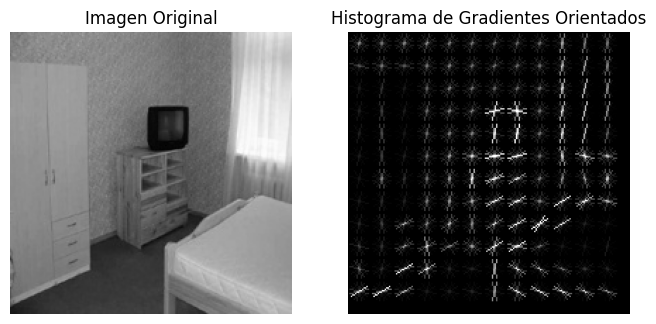

In [38]:

def show_image_hog(image_path):
    # Leer la imagen
    imagen = cv2.imread(image_path)

    # Calcular las características HOG y la imagen HOG
    features, hog_image = hog(
        imagen,
        orientations=8,
        pixels_per_cell=(16, 16),
        cells_per_block=(1, 1),
        visualize=True,
        channel_axis=-1,
    )

    # Crear una figura con dos subgráficos
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

    # Configurar el primer subgráfico con la imagen original
    ax1.axis('off')
    ax1.imshow(cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB))
    ax1.set_title('Imagen Original')

    # Reescalar el histograma para una mejor visualización
    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

    # Configurar el segundo subgráfico con la imagen HOG
    ax2.axis('off')
    ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
    ax2.set_title('Histograma de Gradientes Orientados')

    # Mostrar la figura
    plt.show()

show_image_hog(dataset_filenames[6])


Entrenamos al modelo con los hiperparametros mas optimos segun revisiones literarias. La clave de la eleccion para estos hiperparametros ha sido la realizacion previa de experimentos que no anadiremos en este documento para no engrosar el tiempo de ejecucion del mismo 

In [ ]:
hog_classifier=svm.SVC(C=1.0, gamma='scale', decision_function_shape='ovo') #cross-validated hyper-parameters
hog_classifier.fit(features_list_hog,dataset_labels)

Realizamos alguna prueba para testear su funcionamiento

true label: 4
prediction: [6]


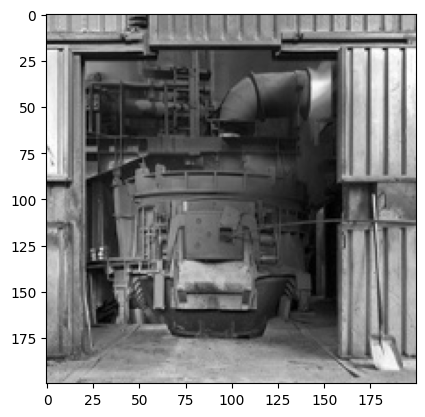

In [24]:
### show a sample classification ###
plot_file(test_filenames[900])
print ('true label:',test_labels[900])
test_hog_features=extract_hog_features(test_filenames[900])
print( 'prediction:',hog_classifier.predict([test_hog_features]))

Una vez entrenamos el modelo podemos proceder a analizar su comportamiento, comenzando con el accuracy

In [12]:
# Calcular la precisión en el conjunto de prueba
y_test_pred = [hog_classifier.predict([extract_hog_features(fname)])[0] for fname in tqdm(test_filenames)]
accuracy_test = accuracy_score(test_labels, y_test_pred)
print(f'Accuracy on test set for hog features model: {accuracy_test}')

  0%|          | 0/2985 [00:00<?, ?it/s]

Accuracy on test set: 0.6016750418760469


Para un analisis mas detallado observaremos las principales metricas de un modelo de este tipo para cada una de las clases haciendo uso de la funcion classification_report

In [ ]:
print (classification_report(test_labels, y_test_pred, target_names=category_names))

Ahora podemos pasar a mostrar la matriz de confusion las predicciones realizadas para cada clase. 
Lo correcto seria observar una diagonal decreciente en la que para cada columna coincidiera el mayor numero de predicciones con la clase correcta, como efectivamente podemos observar en nuestra tabla. 

De esta forma podemos comprobar como el numero de falsos negativos y/o positivos es menor que el de aciertos, lo cual demuestra un correcto funcionamiento del modelo

In [19]:
pd.DataFrame(confusion_matrix(test_labels,y_test_pred),columns = category_names, index = category_names)

,bedroom,coast,forest,highway,industrial,insidecity,kitchen,livingRoom,mountain,office,opencountry,store,street,suburb,tallbuilding
bedroom,47,1,0,1,4,0,9,26,0,14,0,10,1,0,3
coast,0,193,2,19,1,0,0,0,2,1,42,0,0,0,0
forest,0,0,211,0,3,0,0,0,9,0,3,2,0,0,0
highway,1,24,0,106,2,1,0,0,5,2,13,6,0,0,0
industrial,6,4,2,6,55,20,4,9,10,11,6,29,9,3,37
insidecity,5,1,0,2,9,107,17,4,1,12,1,13,8,6,22
kitchen,13,0,0,1,2,3,50,13,0,20,0,3,0,2,3
livingRoom,41,0,0,2,3,4,10,93,0,13,0,14,1,1,7
mountain,0,6,23,6,3,0,0,0,190,2,40,1,0,0,3
office,7,0,0,0,1,3,14,5,0,84,0,0,0,1,0


## Entrenamiento y evaluacion del modelo con vectores de Daisy

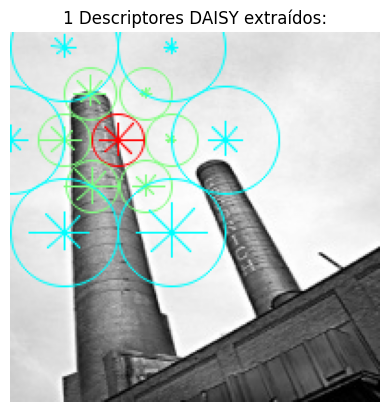

In [28]:
def extract_and_show_daisy(image_path):
    # Leer la imagen
    imagen = io.imread(image_path)
    imagen_gris = color.rgb2gray(imagen)
    # Calcular las características DAISY de la imagen
    descs, descs_img = daisy(imagen_gris, step=180, radius=58, rings=2, histograms=6,
                             orientations=8, visualize=True)

    fig, ax = plt.subplots()
    ax.axis("off")
    ax.imshow(descs_img)
    descs_num = descs.shape[0] * descs.shape[1]
    ax.set_title(f"{descs_num} Descriptores DAISY extraídos:")
    plt.show()

extract_and_show_daisy(dataset_filenames[400])



In [26]:
daisy_classifier=svm.SVC(C=1.0, gamma='scale', decision_function_shape='ovo') #cross-validated hyper-parameters
daisy_classifier.fit(features_list_daisy,dataset_labels)

SVC(decision_function_shape='ovo')

true label: 1
prediction: [1]


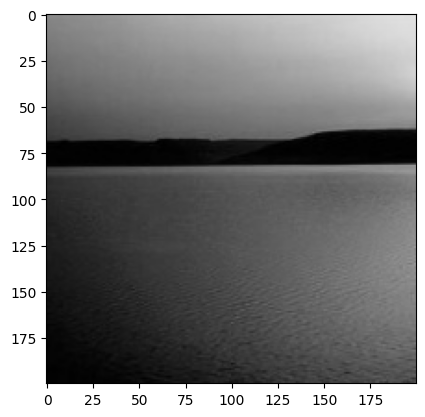

In [32]:
### show a sample classification ###
plot_file(test_filenames[200])
print ('true label:',test_labels[200])
test_daisy_features=extract_daisy_features(test_filenames[200])
print( 'prediction:',daisy_classifier.predict([test_daisy_features]))

In [33]:
y_daisy_pred = [daisy_classifier.predict([extract_daisy_features(fname)])[0] for fname in tqdm(test_filenames)]
accuracy_daisy = accuracy_score(test_labels, y_daisy_pred)
print(f'Accuracy on test set for daisy features model: {accuracy_daisy}')

  0%|          | 0/2985 [00:00<?, ?it/s]

Accuracy on test set: 0.5366834170854271


In [35]:
print (classification_report(test_labels, y_daisy_pred, target_names=category_names))
pd.DataFrame(confusion_matrix(test_labels,y_daisy_pred),columns = category_names, index = category_names)

              precision    recall  f1-score   support

     bedroom       0.26      0.29      0.27       116
       coast       0.73      0.74      0.74       260
      forest       0.71      0.83      0.76       228
     highway       0.68      0.69      0.69       160
  industrial       0.28      0.22      0.25       211
  insidecity       0.44      0.38      0.41       208
     kitchen       0.35      0.29      0.32       110
  livingRoom       0.53      0.38      0.44       189
    mountain       0.53      0.47      0.50       274
      office       0.36      0.77      0.49       115
 opencountry       0.60      0.63      0.62       310
       store       0.38      0.60      0.47       215
      street       0.82      0.59      0.69       192
      suburb       0.69      0.62      0.65       141
tallbuilding       0.60      0.39      0.47       256

    accuracy                           0.54      2985
   macro avg       0.53      0.53      0.52      2985
weighted avg       0.55   

,bedroom,coast,forest,highway,industrial,insidecity,kitchen,livingRoom,mountain,office,opencountry,store,street,suburb,tallbuilding
bedroom,34,0,0,1,14,0,11,14,2,18,1,10,1,3,7
coast,0,193,3,21,0,1,0,0,2,5,34,0,0,1,0
forest,0,0,190,1,3,3,1,0,19,3,0,7,0,1,0
highway,0,14,1,111,0,2,1,1,2,2,18,6,2,0,0
industrial,19,4,9,3,46,18,4,5,11,23,6,34,1,2,26
insidecity,1,6,5,0,6,80,4,1,18,9,9,49,10,7,3
kitchen,19,5,0,0,10,2,32,11,0,14,1,11,0,1,4
livingRoom,29,1,0,2,9,6,17,72,2,13,2,26,0,4,6
mountain,4,6,18,6,9,5,3,1,130,12,46,15,4,6,9
office,8,1,0,0,1,1,6,6,0,88,0,0,0,1,3


## Entrenamiento y evaluacion del modelo con vectores de Local Binary Patterns

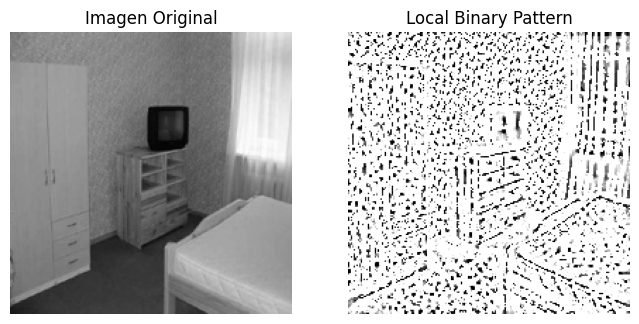

In [36]:
def show_image_lbp(image_path):
    # Leer la imagen
    imagen = cv2.imread(image_path)

    imagen_gris = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)

    radius = 3
    n_points = 8 * radius
    lbp_image = local_binary_pattern(imagen_gris, n_points, radius, method='uniform')

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

    ax1.axis('off')
    ax1.imshow(cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB))
    ax1.set_title('Imagen Original')

    lbp_image_rescaled = exposure.rescale_intensity(lbp_image, in_range=(0, 10))

    ax2.axis('off')
    ax2.imshow(lbp_image_rescaled, cmap=plt.cm.gray)
    ax2.set_title('Local Binary Pattern')

    plt.show()

show_image_lbp(dataset_filenames[6])

In [37]:
lbp_classifier=svm.SVC(C=1.0, gamma='scale', decision_function_shape='ovo') #cross-validated hyper-parameters
lbp_classifier.fit(features_list_lbp,dataset_labels)

SVC(decision_function_shape='ovo')

In [ ]:
### show a sample classification ###
plot_file(test_filenames[456])
print ('true label:',test_labels[456])
test_lbp_features=extract_lbp_features(test_filenames[456])
print( 'prediction:',dlbp_classifier.predict([test_lbp_features]))

In [ ]:
y_lbp_pred = [lbp_classifier.predict([extract_lbp_features(fname)])[0] for fname in tqdm(test_filenames)]
accuracy_lbp = accuracy_score(test_labels, y_lbp_pred)
print(f'Accuracy on test set for local binary pattern features: {accuracy_lbp}')

In [ ]:
print (classification_report(test_labels, y_lbp_pred, target_names=category_names))
pd.DataFrame(confusion_matrix(test_labels,y_lbp_pred),columns = category_names, index = category_names)